# Denoising autoencoder

In [4]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
#load data
batch_size = 4
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([3, 32, 122])


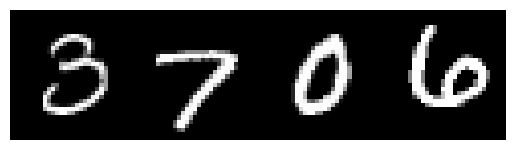

3     7     0     6    


In [6]:
#show original images
def imshow(img):
    print(img.shape)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
classes = list(str(i) for i in range(10))

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
#define model
def EnocodeLayer(inp, out, ks=3, s=1, p=1):
    return nn.Conv2d(inp, out, kernel_size=ks, stride=s, padding=p)

def DecodeLayer(inp, out, ks, s):
    return nn.ConvTranspose2d(inp, out, kernel_size=ks, stride=s)

class DenoisingAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.sqs = nn.Sequential(
            EnocodeLayer(1, 32), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            EnocodeLayer(32, 16), nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            EnocodeLayer(16, 8), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            DecodeLayer(8, 8, 3, 2), nn.ReLU(),
            DecodeLayer(8, 16, 2, 2), nn.ReLU(),
            DecodeLayer(16, 32, 2, 2), nn.ReLU(),
            
            EnocodeLayer(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.sqs(x)

In [8]:
#initialize model
w = torch.empty(3, 5)
nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
net = DenoisingAutoEncoder()

In [9]:
#define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [10]:
#train model
n_epoch = 4
noise_factor = 0.5
for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #add random noise
        noisy_inputs = inputs + noise_factor * torch.randn(*inputs.shape)
        noisy_inputs = np.clip(noisy_inputs, 0., 1.)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 14000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.057
[2,  2000] loss: 0.031
[3,  2000] loss: 0.028
[4,  2000] loss: 0.027
Finished Training


NameError: name 'output' is not defined

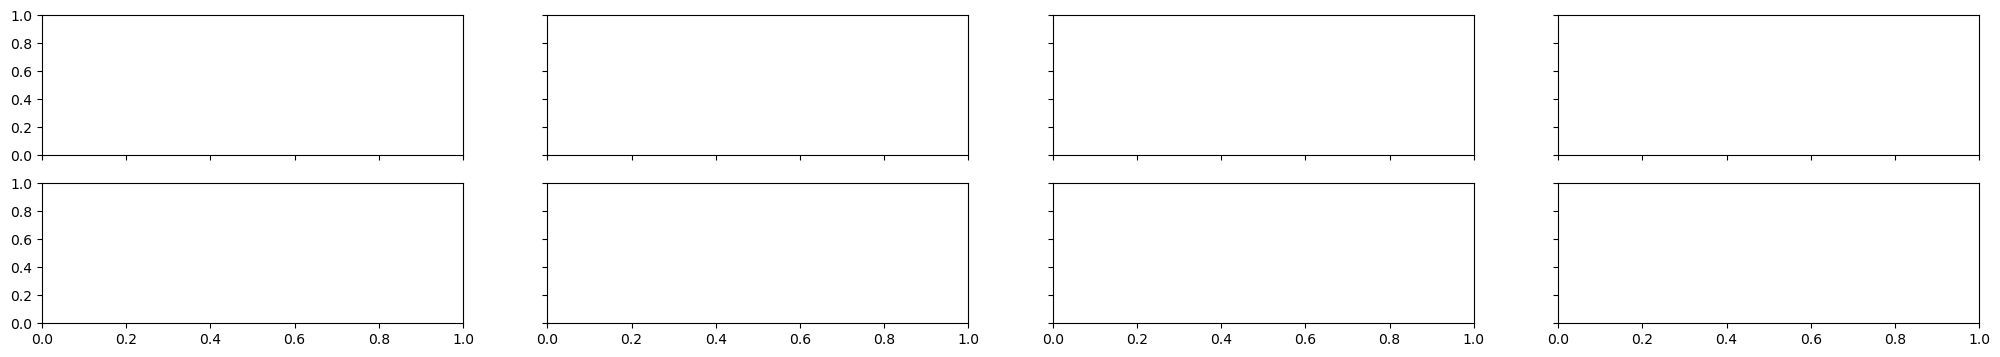

In [11]:
# evaluate model
dataiter = iter(testloader)
inputs, labels = dataiter.next()

# add noise to the test images
noisy_inputs = inputs + noise_factor * torch.randn(*inputs.shape)
noisy_inputs = np.clip(noisy_inputs, 0., 1.)

# get sample outputs
outputs = net(noisy_inputs)
noisy_inputs = noisy_inputs.numpy()
outputs = outputs.view(batch_size, 1, 28, 28)
outputs = outputs.detach().numpy()

#show images
fig, axes = plt.subplots(nrows=2, ncols=batch_size, sharex=True, sharey=True, figsize=(25,4))
for noisy_inputs, row in zip([noisy_inputs, output], axes):
    for img, ax in zip(noisy_inputs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
#compute mean residual
mean_residuals = np.zeros((28,28))
n = 0
outputs_list = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        #add random noise
        noisy_inputs = inputs + noise_factor * torch.randn(*inputs.shape)
        noisy_inputs = np.clip(noisy_inputs, 0., 1.)
        # calculate outputs by running images through the network
        outputs = net(noisy_inputs)
        outputs_tmp = outputs.detach().numpy().squeeze()
        outputs_list.append(outputs_tmp)
        # compute residual
        residuals_tmp = inputs - outputs
        residuals_tmp = np.squeeze(residuals_tmp)
        residuals_tmp = residuals_tmp.detach().numpy()
        mean_residuals_tmp = np.mean(residuals_tmp, axis=0)
        mean_residuals += mean_residuals_tmp
        n += 1

mean_residuals = mean_residuals/n

(-0.5, 27.5, 27.5, -0.5)

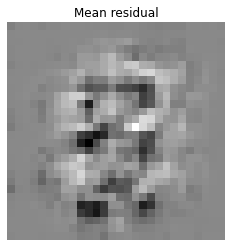

In [ ]:
#show mean residual
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(mean_residuals, cmap='gray')
ax.set(title="Mean residual")
plt.axis('off')

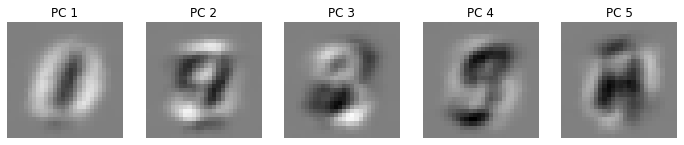

In [ ]:
#perform PCA and show first five principla components
outputs_arr = np.array(outputs_list)
outputs_arr = outputs_arr.reshape(-1, 28*28)
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(outputs_arr)
fig = plt.figure(figsize=(12, 4))
axes = []
for i in range(n_components):
    ax_ = fig.add_subplot(1, n_components, i+1)
    ax_.imshow(pca.components_[i].reshape(28,28), interpolation='nearest', clim=(-.15, .15), cmap='gray')
    ax_.set_title(f'PC {i+1}')
    ax_.axis('off')

    axes.append(ax_)